# Walter Piper - Springboard Capstone 2 - Exploratory Data Analysis (Part 1 of 2)
# WESAD Dataset (Wearable Affect and Stress Detection)
## The original data came with wearable device-recorded data and self-report questionnaire data.
## I have transformed and cleaned device-recorded data for further use in analysis.
## See other notebooks for further details of transformations.
### Briefly, 
### * ECG data was run through a hamilton segmenter algorithm from the biosppy package to extract heart beat times, and mistakes by the algorithm were corrected with a custom user interface using ipywidgets and bqplot. (See "Capstone2-ECG-Cleaning.ipnyb" or "Capstone2-ECG-to-IBI-Transformations.ipynb")
### * Electrodermal activity was processed to extract discrete galvanic skin responses (GSR), indicative of sympathetic nervous system activation. (See "Electrodermal preprocessing.ipynb")
### * Electromyography data (EMG) was high-pass filtered, squared, and smoothed. (See "Capstone2-EMG.ipynb")
### * "Capstone2-EMG.ipynb" also includes energy computations for both chest and wrist accelerometers, as well as smoothing and derivative computations of Respiration and Blood Volume Pulse data.

# Each of the 15 subjects has an experiment labeling time series that indicates the experimental task in progress at each time point. The relevant tasks are Baseline (coded as "1"), the Trier Social Stress Task (coded as "2"), an amusement segment (coded as "3"), and paced breathing meditation (coded as "4"). These segment codes will be used to group data for exploratory data analysis in this notebook.

# Seaborn will be good for making exploratory figures because it easily groups data before plotting.
## This may require a melted dataframe after aggregations of data for each segment and for each subject.
### The aggregation functions for each variable will be:
### * Where InterBeat_Interval is a pandas Series:
#### Heart rate (beats per minute) --> HR = np.mean(60 / InterBeat_Interval.values)
#### Heart rate variability --> HRV or RMSSD = Root mean square of successive differences --> np.sqrt(np.sum((InterBeat_Interval.diff().dropna())**2))
### * Where GSR is a pandas Series of Boolean values, and time is total time range of the segment.
#### Galvantic skin responses per minute --> GSR_rate = GSR.sum() / (time/60)
### * EMG, ACC_chest, and ACC_wrist will get an energy density calculation (where generic pandas Series X is a enegy time series of previously squared values)
#### Energy_per_minute = X.sum() / (time/60)
### * Respiration will have autocorrelation computed across segment, and then energy will be obtained by taking the sum of squares of the autocorr plot.
#### Resp_autocorr_energy:
##### import statsmodels.api as sm
##### #calculate autocorrelations
##### sm.tsa.acf(Resp_y) # Where Resp_y is smoothed Resp values
##### Resp_autocorr_energy = np.sum(x[1:7000]**2)


# After calculating the above for each segment, the aggregated results will be melted into a single DataFrame with pd.melt().
# Then seaborn can plot each variable in a separate swarm plot, grouped by experimental segment.
# After that, bivariate correlations will be examined, with both aggregated device measures and questionnaire measures.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [2]:
IBI_path_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/processed/*IBI*.csv')
EDA_path_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/processed/*EDA*.csv')
#q_file_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/*Questions.csv')
IBI_dict = {IBI_path.split('\\')[-1].split('_')[0]: IBI_path for IBI_path in IBI_path_list}
EDA_dict = {EDA_path.split('\\')[-1].split('_')[1]: EDA_path for EDA_path in EDA_path_list}
#Q_dict = {q_path.split('\\')[-1].split('_')[0]: q_path for q_path in q_file_list}
"""for IBI_path, EDA_path in zip(IBI_path_list, EDA_path_list):
    IBIpath = IBI_path.split('\\')[-1].split('_')[0]
    EDApath = EDA_path.split('\\')[-1].split('_')[1]
    print(IBIpath)
    print(IBI_path)
    print(EDApath)
    print(EDA_path)
    print('\n')
"""
for k,v in IBI_dict.items():
    print(k,':',v)
print('\n')
for k,v in EDA_dict.items():
    print(k,':',v)
print('\n')
#for k,v in Q_dict.items():
#    print(k,':',v)

S10 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S10_IBI_df.csv
S11 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S11_IBI_df.csv
S13 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S13_IBI_df.csv
S14 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S14_IBI_df.csv
S15 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S15_IBI_df.csv
S16 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S16_IBI_df.csv
S17 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S17_IBI_df.csv
S2 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S2_IBI_df.csv
S3 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S3_IBI_df.csv
S4 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S4_IBI_df.csv
S5 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S5_IBI_df.csv
S6 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S6_IBI_df.csv
S7 : D:/Springboard/Capstone2/WESAD/Capstone2/data/processed\S7_IBI_df.csv
S8 : D:/Spr

In [7]:
# Check for data files from all 15 subjects
path = 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\'
#Subjects S1 and S12 had sensor errors and are not included in download
pkl_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*.pkl', recursive=True)[0] for i in range(2,18,1) if i != 12} #Signal data
#quest_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*.csv', recursive=True)[0] for i in range(2,18,1) if i != 12} #Questionnaires
#subjinfo_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*readme.txt', recursive=True)[0] for i in range(2,18,1) if i != 12} #Extra self-report data, collected start of session

for dictionary, name in zip([pkl_dict], ['signal data']):#, quest_dict, subjinfo_dict], ['signal data', 'affective questionnaires', 'subject-level info']):
    print(name,':')
    for subjectID, pathstring in dictionary.items():
        print(subjectID,': ',pathstring)
    print('\n')

signal data :
S2 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2.pkl
S3 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3.pkl
S4 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S4\S4.pkl
S5 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S5\S5.pkl
S6 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S6\S6.pkl
S7 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S7\S7.pkl
S8 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S8\S8.pkl
S9 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S9\S9.pkl
S10 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S10\S10.pkl
S11 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S11\S11.pkl
S13 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S13\S13.pkl
S14 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S14\S14.pkl
S15 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S15\S15.pkl
S16 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S16\S16.pkl
S17 :  D:\Springboard\Capstone2\WESAD\Capsto

In [21]:
def check_pkl_raw(Subj_ID, pkl_filepaths, return_data=False, suppress_histograms=False):
    """
    Check the integrity of raw time series data for a given subject.
    Input: 
        Subj_ID: string ('S2'-'S17')
        pkl_filepaths: dictionary of paths with Subj_ID as key
        return_data: Boolean. Indicates whether data should be returned at end of function
    Output (if requested by return_data keyword):
        dict_signal_single_subject: Dictionary containing data for the subject Subj_ID. 
    """    
    # LOAD DICTIONARY FROM PKL FILE
    dict_signal_single_subject = pd.read_pickle(pkl_filepaths[Subj_ID]) # Load pickle file
    print('Dictionary from .pkl file has keys:',dict_signal_single_subject.keys())
    # Check type, length of each key's value
    for key in dict_signal_single_subject.keys():
        print(key, ' is type:' , type(dict_signal_single_subject[key]), ' with length:', len(dict_signal_single_subject[key]))
        
    print('\n')
    print('SUBJECT #:',dict_signal_single_subject['subject'])
    
    # LABEL VALUES SHOW TEMPORAL STRUCTURE OF EXPERIMENT
    print('\n')
    print('LABEL unique values:',np.unique(dict_signal_single_subject['label'])) 
    # readme.pdf described label array as labels for the different experimental segments within the research design
    label_dict = {'0':'not defined/transient' ,'1':'baseline' ,'2':'stress' ,'3':'amusement' ,'4':'meditation' ,'5':'ignore' ,'6':'ignore' ,'7':'ignore' }
    print(label_dict)
    plt.plot(np.linspace(0, len(dict_signal_single_subject['label'])/700, len(dict_signal_single_subject['label'])), dict_signal_single_subject['label'])
    plt.title(dict_signal_single_subject['subject']+' label array')
    plt.xlabel('time (s)')
    plt.ylabel('LABEL CODE')
    plt.show()
    
    # EXAMINE PHYSIOLOGY SIGNAL ARRAYS
    if suppress_histograms == False:
        print('\n')
        print('SIGNAL KEYS:',dict_signal_single_subject['signal'].keys())
        print('chest:', type(dict_signal_single_subject['signal']['chest']), 'has keys:', dict_signal_single_subject['signal']['chest'].keys()) # Chest = RespiBAN data
        print('wrist:',type(dict_signal_single_subject['signal']['wrist']), 'has keys:', dict_signal_single_subject['signal']['wrist'].keys()) # Wrist = Empatica E4 data
        Wrist_Hz_dict = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4} # Frequency for Wrist device channels
        Chest_Hz_dict = {'ACC':700, 'ECG':700, 'EMG':700, 'EDA':700, 'Temp':700, 'Resp':700} # Frequency for Chest device channels
        # Plot histograms for each recording channel
        for device, device_name, Hz_dict in zip(['chest', 'wrist'], ['Chest (RespiBAN) sensor', 'Wrist (Empatica E4) sensor'], [Chest_Hz_dict, Wrist_Hz_dict]):
            print('\n',device_name)
            fig, axes = plt.subplots(1, len(dict_signal_single_subject['signal'][device].keys()), figsize=[16,2.5])
            for key, ax in zip(dict_signal_single_subject['signal'][device].keys(), axes):
                sig_array = dict_signal_single_subject['signal'][device][key]
                print(key, 'array has shape:', sig_array.shape, 'at',Hz_dict[key], 'Hz for a total of ', sig_array.shape[0]/Hz_dict[key],'seconds')
                sample = np.random.choice(sig_array.flatten(), size=10000)
                ax.hist(sample, bins=20)
                ax.set_title(key)
            fig.suptitle(device_name+'\nHistograms of 10000 randomly sampled datapoints')
            plt.tight_layout()
            plt.show()
        print('\n----------------------------------------------------------------------------\n')

    if return_data == True:
        return dict_signal_single_subject

# Detect time boundaries for each subject

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4255300
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S2


LABEL unique values: [0 1 2 3 4 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


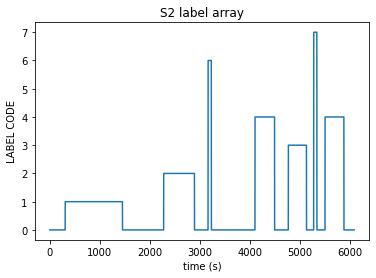

,START,END
BASELINE,306.547143,1450.545714
SOCIAL STRESS,2273.545714,2888.544286
AMUSEMENT,4763.547143,5125.545714
MEDITATION 1,4097.547143,4488.545714
MEDITATION 2,5496.547143,5873.547143


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4545100
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S3


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


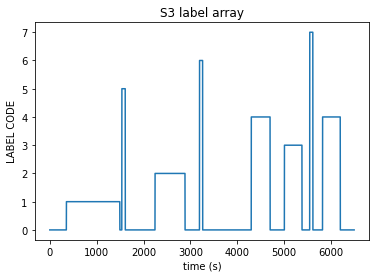

,START,END
BASELINE,352.854286,1492.852857
SOCIAL STRESS,2243.854286,2883.852857
AMUSEMENT,5003.854286,5378.852857
MEDITATION 1,4296.854286,4698.854286
MEDITATION 2,5817.852857,6195.854286


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4496100
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S4


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


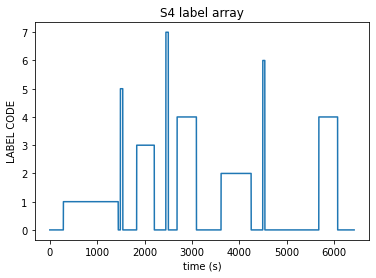

,START,END
BASELINE,285.292857,1443.292857
SOCIAL STRESS,3613.294286,4248.292857
AMUSEMENT,1832.294286,2204.292857
MEDITATION 1,2685.294286,3093.294286
MEDITATION 2,5676.294286,6073.294286


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4380600
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S5


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


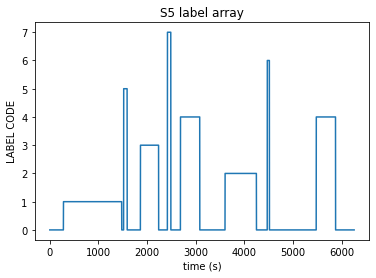

,START,END
BASELINE,279.371429,1477.370000
SOCIAL STRESS,3602.371429,4247.370000
AMUSEMENT,1862.371429,2236.370000
MEDITATION 1,2685.371429,3082.371429
MEDITATION 2,5477.371429,5874.371429


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4949700
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S6


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


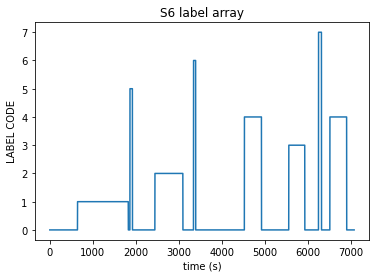

,START,END
BASELINE,642.695714,1822.694286
SOCIAL STRESS,2440.695714,3090.694286
AMUSEMENT,5550.695714,5922.694286
MEDITATION 1,4519.695714,4916.695714
MEDITATION 2,6505.695714,6895.695714


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3666600
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S7


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


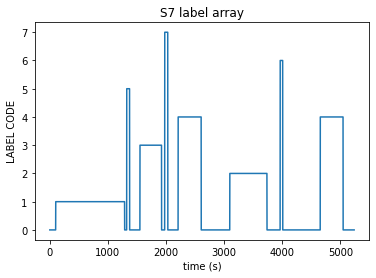

,START,END
BASELINE,100.631429,1286.630000
SOCIAL STRESS,3096.631429,3736.630000
AMUSEMENT,1550.630000,1922.630000
MEDITATION 1,2207.631429,2604.631429
MEDITATION 2,4653.630000,5046.631429


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3826200
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S8


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


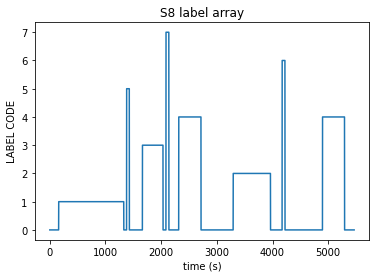

,START,END
BASELINE,158.531429,1327.530000
SOCIAL STRESS,3292.531429,3962.530000
AMUSEMENT,1662.531429,2032.528571
MEDITATION 1,2314.531429,2714.531429
MEDITATION 2,4896.531429,5292.531429


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3656100
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S9


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


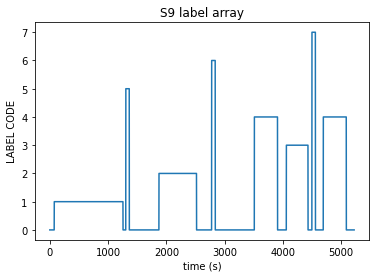

,START,END
BASELINE,75.245714,1255.244286
SOCIAL STRESS,1872.245714,2517.244286
AMUSEMENT,4058.245714,4430.244286
MEDITATION 1,3509.245714,3907.245714
MEDITATION 2,4692.245714,5087.245714


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3847200
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S10


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


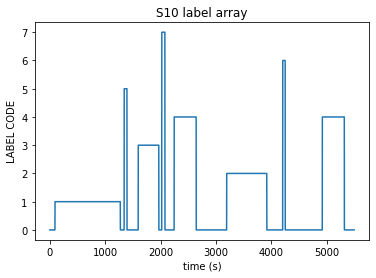

,START,END
BASELINE,92.857143,1272.855714
SOCIAL STRESS,3192.855714,3917.854286
AMUSEMENT,1595.857143,1967.855714
MEDITATION 1,2244.857143,2642.857143
MEDITATION 2,4919.857143,5317.857143


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3663100
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S11


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


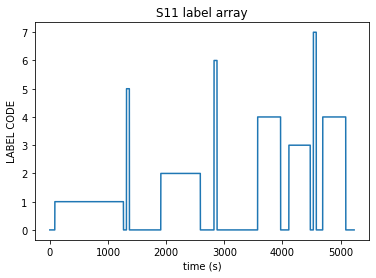

,START,END
BASELINE,85.624286,1265.622857
SOCIAL STRESS,1907.624286,2587.622857
AMUSEMENT,4109.624286,4477.622857
MEDITATION 1,3572.622857,3967.624286
MEDITATION 2,4691.624286,5087.624286


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3875900
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S13


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


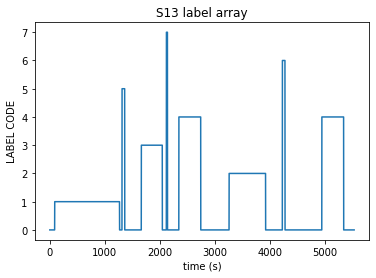

,START,END
BASELINE,87.905714,1267.905714
SOCIAL STRESS,3260.907143,3924.905714
AMUSEMENT,1663.907143,2045.905714
MEDITATION 1,2346.907143,2744.905714
MEDITATION 2,4947.907143,5344.907143


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3883600
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S14


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


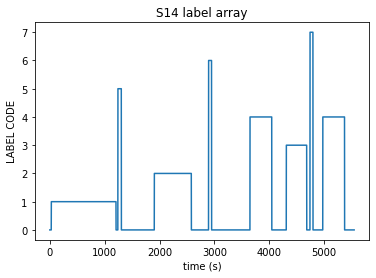

,START,END
BASELINE,26.195714,1206.194286
SOCIAL STRESS,1904.195714,2579.194286
AMUSEMENT,4310.194286,4682.194286
MEDITATION 1,3648.195714,4045.195714
MEDITATION 2,4975.195714,5372.195714


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3676400
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S15


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


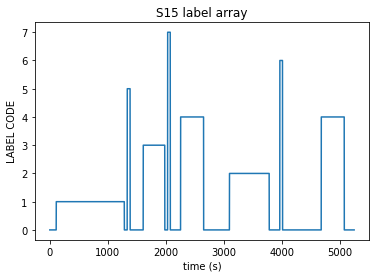

,START,END
BASELINE,110.23,1285.228571
SOCIAL STRESS,3099.23,3785.228571
AMUSEMENT,1611.23,1983.228571
MEDITATION 1,2256.23,2653.230000
MEDITATION 2,4683.23,5080.228571


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3941700
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S16


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


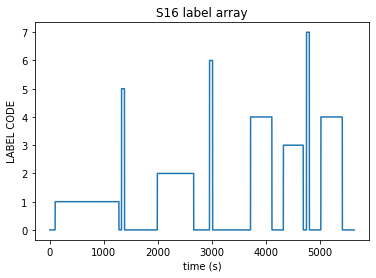

,START,END
BASELINE,98.370000,1278.368571
SOCIAL STRESS,1988.368571,2661.368571
AMUSEMENT,4320.370000,4688.368571
MEDITATION 1,3713.370000,4108.368571
MEDITATION 2,5014.370000,5411.370000


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4144000
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S17


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


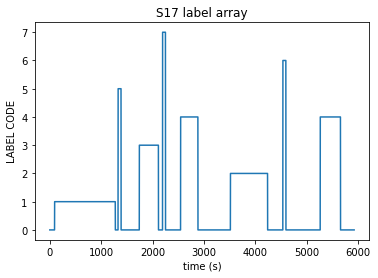

,START,END
BASELINE,92.234286,1273.232857
SOCIAL STRESS,3512.234286,4235.232857
AMUSEMENT,1740.234286,2112.232857
MEDITATION 1,2543.234286,2880.234286
MEDITATION 2,5259.234286,5653.234286


In [22]:
time_boundary_dict = dict()
# For each subject
for Subj_ID in pkl_dict.keys(): 
    # Load experiment segment labels and extract time boundaries
    signal_data = check_pkl_raw(Subj_ID, pkl_dict, return_data=True, suppress_histograms=True)
    label_array = signal_data['label']
    #print("label_array.shape", label_array.shape)
    label_array_times = np.linspace(0, len(label_array)/700, len(label_array), endpoint=False)
    
    # Create masks for experimental segments
    BASELINE_MASK = label_array == 1
    SOCIAL_STRESS_MASK = label_array == 2
    AMUSEMENT_MASK = label_array == 3
    MEDITATION_MASK = label_array == 4
    
    # First 3 categories only have one segment per subject, so time boundaries can be extracted with min and max.
    BASELINE_START_END_TIMES = (np.min(label_array_times[BASELINE_MASK]), np.max(label_array_times[BASELINE_MASK]))
    SOCIAL_STRESS_START_END_TIMES = (np.min(label_array_times[SOCIAL_STRESS_MASK]), np.max(label_array_times[SOCIAL_STRESS_MASK]))
    AMUSEMENT_START_END_TIMES = (np.min(label_array_times[AMUSEMENT_MASK]), np.max(label_array_times[AMUSEMENT_MASK]))
    #print('BASELINE_START_END_TIMES', BASELINE_START_END_TIMES)
    #print('SOCIAL_STRESS_START_END_TIMES', SOCIAL_STRESS_START_END_TIMES)
    #print('AMUSEMENT_START_END_TIMES', AMUSEMENT_START_END_TIMES)
    
    # Meditation category has two segments that both need a min and max. How do we separate these 2 segments?
    # Treat mask as a square wave and detect rise and fall edges.
    MEDITATION_TIMES_DIFF_y = np.array(MEDITATION_MASK[1:], dtype='int') - np.array(MEDITATION_MASK[:-1], dtype='int')
    MEDITATION_TIMES_DIFF_x = np.arange(1, 1+len(MEDITATION_TIMES_DIFF_y))
    MED_TIME_DIFF_Series = pd.Series(MEDITATION_TIMES_DIFF_y, index=MEDITATION_TIMES_DIFF_x)
    RISE_FALL_SERIES = MED_TIME_DIFF_Series.loc[MED_TIME_DIFF_Series != 0]
    
    MEDITATION_1_START_END_TIMES = (label_array_times[RISE_FALL_SERIES.index[0]], label_array_times[RISE_FALL_SERIES.index[1]])
    MEDITATION_2_START_END_TIMES = (label_array_times[RISE_FALL_SERIES.index[2]], label_array_times[RISE_FALL_SERIES.index[3]])
    #print('\nRISE AND FALL OF MEDITATION TIMES:\n', MED_TIME_DIFF_Series.loc[MED_TIME_DIFF_Series != 0])
    #print('\n')
    #print('MEDITATION_1_START_END_TIMES', MEDITATION_1_START_END_TIMES)
    #print('MEDITATION_2_START_END_TIMES', MEDITATION_2_START_END_TIMES)
    
    segment_names = ['BASELINE','SOCIAL STRESS','AMUSEMENT','MEDITATION 1','MEDITATION 2']
    boundary_times = [BASELINE_START_END_TIMES, SOCIAL_STRESS_START_END_TIMES, AMUSEMENT_START_END_TIMES,
                     MEDITATION_1_START_END_TIMES, MEDITATION_2_START_END_TIMES]
    boundary_dict = {key: val for key, val in zip(segment_names, boundary_times)}
    boundary_df = pd.DataFrame(boundary_dict, index=['START','END']).T
    display(boundary_df)
    
    time_boundary_dict[Subj_ID] = boundary_df

In [23]:
time_boundary_dict

{'S2':                      START          END
 BASELINE        306.547143  1450.545714
 SOCIAL STRESS  2273.545714  2888.544286
 AMUSEMENT      4763.547143  5125.545714
 MEDITATION 1   4097.547143  4488.545714
 MEDITATION 2   5496.547143  5873.547143,
 'S3':                      START          END
 BASELINE        352.854286  1492.852857
 SOCIAL STRESS  2243.854286  2883.852857
 AMUSEMENT      5003.854286  5378.852857
 MEDITATION 1   4296.854286  4698.854286
 MEDITATION 2   5817.852857  6195.854286,
 'S4':                      START          END
 BASELINE        285.292857  1443.292857
 SOCIAL STRESS  3613.294286  4248.292857
 AMUSEMENT      1832.294286  2204.292857
 MEDITATION 1   2685.294286  3093.294286
 MEDITATION 2   5676.294286  6073.294286,
 'S5':                      START          END
 BASELINE        279.371429  1477.370000
 SOCIAL STRESS  3602.371429  4247.370000
 AMUSEMENT      1862.371429  2236.370000
 MEDITATION 1   2685.371429  3082.371429
 MEDITATION 2   5477.371429  5

### * Where InterBeat_Interval is a pandas Series:
#### Heart rate (beats per minute) --> HR = np.mean(60 / InterBeat_Interval.values)
#### Heart rate variability --> HRV or RMSSD = Root mean square of successive differences --> np.sqrt(np.sum((InterBeat_Interval.diff().dropna())**2))

In [62]:
# For each subject
for Subj_ID in pkl_dict.keys():
    # Load from filepath in IBI_dict
    IBI_file = IBI_dict[Subj_ID]
    IBI_df = pd.read_csv(IBI_file, usecols=[1,2])
    #print('\n', IBI_df.info())
    #display(IBI_df.head())
    
    # Collect heart beat data from segments between time boundaries from time_boundary_dict
    # and aggregate Heart rate and Heart rate variability.
    HR_list = []
    HRV_list = []
    for index, row in time_boundary_dict[Subj_ID].iterrows():
        #print(index, row)
        temp_df = IBI_df.loc[np.logical_and(IBI_df.iloc[:, 0] > row['START'], IBI_df.iloc[:, 0] < row['END'])]
        #display( temp_df.head() )
        #display( temp_df.tail() )
        HR = np.mean(60/temp_df.iloc[:, 1])
        HR_list.append(HR)
        HRV = np.sqrt(np.mean((temp_df.iloc[:, 1].diff().dropna())**2))
        HRV_list.append(HRV)
    time_boundary_dict[Subj_ID]['HR_avg'] = HR_list
    time_boundary_dict[Subj_ID]['HRV_RMSSD'] = HRV_list
    print(Subj_ID)
    display(time_boundary_dict[Subj_ID])
    print('\n')
        
        

S2


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,306.547143,1450.545714,73.111502,0.059168,1.416086,0.078571,39.810541,212912.101539,39.815329
SOCIAL STRESS,2273.545714,2888.544286,77.637429,0.041422,6.926845,0.086624,46.373057,134460.409896,39.875408
AMUSEMENT,4763.547143,5125.545714,66.824498,0.087070,3.480677,0.076036,37.805933,59604.102621,39.744865
MEDITATION 1,4097.547143,4488.545714,68.398768,0.069900,0.153453,0.042625,36.299269,3327.480188,39.815475
MEDITATION 2,5496.547143,5873.547143,66.679367,0.068665,0.000000,0.042642,37.569847,5121.962865,39.869583




S3


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,352.854286,1492.852857,55.151696,0.122515,0.736843,0.465763,39.640777,62896.920923,39.874629
SOCIAL STRESS,2243.854286,2883.852857,89.817856,0.059993,6.468764,1.090791,1979.319727,248581.492369,39.745474
AMUSEMENT,5003.854286,5378.852857,55.628589,0.132283,1.600006,0.121614,46.442231,38658.867272,39.866479
MEDITATION 1,4296.854286,4698.854286,54.271761,0.161677,0.447761,0.054394,42.388568,6072.985075,39.971116
MEDITATION 2,5817.852857,6195.854286,52.793517,0.183336,0.317459,0.040401,40.330901,16746.444647,39.965290




S4


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,285.292857,1443.292857,61.225992,0.090640,0.362694,0.079953,36.071238,35439.689119,39.854399
SOCIAL STRESS,3613.294286,4248.292857,80.611601,0.042970,11.811050,0.205971,43.905658,402410.984052,39.831077
AMUSEMENT,1832.294286,2204.292857,62.433599,0.079716,0.483873,0.056340,36.618681,35963.363915,39.858086
MEDITATION 1,2685.294286,3093.294286,63.742997,0.096670,0.588235,0.050638,36.130997,22135.735294,39.809929
MEDITATION 2,5676.294286,6073.294286,63.119466,0.068488,0.604534,0.069472,40.887371,39665.289673,39.899296




S5


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,279.371429,1477.370000,63.104824,0.030393,0.150251,0.188883,38.092655,53757.159262,39.883003
SOCIAL STRESS,3602.371429,4247.370000,90.328285,0.016928,9.488393,0.149436,66.078710,28825.924310,39.872088
AMUSEMENT,1862.371429,2236.370000,66.703168,0.031240,2.887712,0.060266,38.464308,4618.252935,39.872229
MEDITATION 1,2685.371429,3082.371429,64.483254,0.027708,0.453401,0.041136,37.903063,11707.556675,39.949174
MEDITATION 2,5477.371429,5874.371429,64.019277,0.032811,0.453401,0.057201,38.564713,24121.360202,39.940648




S6


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,642.695714,1822.694286,69.870500,0.038623,0.101695,0.294816,38.281271,61160.768960,39.883995
SOCIAL STRESS,2440.695714,3090.694286,79.520219,0.051069,7.476940,0.120408,59.310025,119363.616184,39.882734
AMUSEMENT,5550.695714,5922.694286,66.343324,0.042422,0.161291,0.166775,41.888400,33419.160596,39.833522
MEDITATION 1,4519.695714,4916.695714,67.795770,0.058597,0.151134,0.043207,37.827609,11399.697733,39.950909
MEDITATION 2,6505.695714,6895.695714,67.060430,0.051299,1.692308,0.055038,37.364852,23864.153846,39.925175




S7


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,100.631429,1286.630000,71.477519,0.054836,0.303542,0.248690,54.017206,23329.910058,39.839072
SOCIAL STRESS,3096.631429,3736.630000,87.291616,0.107005,12.562528,0.255248,144.657055,716204.442421,39.816788
AMUSEMENT,1550.630000,1922.630000,58.769387,0.078870,0.483871,0.046426,49.024908,3165.483871,39.785991
MEDITATION 1,2207.631429,2604.631429,61.509563,0.108139,0.151134,0.044559,48.115096,3237.884131,39.962368
MEDITATION 2,4653.630000,5046.631429,62.385411,0.124564,0.000000,0.052302,53.438273,3229.148567,39.969712




S8


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,158.531429,1327.530000,71.296780,0.052162,0.923868,0.182733,40.525167,5.733697e+04,39.829433
SOCIAL STRESS,3292.531429,3962.530000,91.659792,0.044863,3.671650,0.299602,117.799825,1.001532e+06,39.853071
AMUSEMENT,1662.531429,2032.528571,70.394738,0.078054,1.297307,0.111138,40.367701,3.434605e+04,39.867437
MEDITATION 1,2314.531429,2714.531429,68.272511,0.085591,3.450000,0.052450,40.235753,1.394520e+04,39.960228
MEDITATION 2,4896.531429,5292.531429,73.114081,0.069473,1.818182,0.043066,38.052139,3.485000e+03,39.955638




S9


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,75.245714,1255.244286,77.201461,0.035584,0.966103,0.206134,44.616283,55180.185448,39.888588
SOCIAL STRESS,1872.245714,2517.244286,80.875831,0.042608,11.255839,0.168326,54.558478,137413.606675,39.885880
AMUSEMENT,4058.245714,4430.244286,86.050774,0.015391,4.838728,0.152912,41.211762,13410.374080,39.854072
MEDITATION 1,3509.245714,3907.245714,72.513226,0.038241,0.301508,0.047966,42.008943,4546.582915,39.940681
MEDITATION 2,4692.245714,5087.245714,73.160608,0.033948,1.670886,0.043515,43.932399,9569.012658,39.946256




S10


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,92.857143,1272.855714,99.254877,0.021324,1.474578,0.086758,41.484870,70552.865076,39.854762
SOCIAL STRESS,3192.855714,3917.854286,108.885452,0.036197,7.034497,0.072892,60.285079,205625.370690,39.877123
AMUSEMENT,1595.857143,1967.855714,76.685501,0.045500,0.645164,0.056127,37.236616,5921.796935,39.833505
MEDITATION 1,2244.857143,2642.857143,76.575485,0.050339,0.452261,0.043398,36.898830,3769.748744,39.946422
MEDITATION 2,4919.857143,5317.857143,77.959140,0.038401,2.864322,0.042223,37.996132,10663.869347,39.826178




S11


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,85.624286,1265.622857,74.602240,0.049722,1.016950,0.131591,36.730163,1.322803e+05,39.857257
SOCIAL STRESS,1907.624286,2587.622857,125.105321,0.008242,7.147074,0.140935,55.801353,1.102025e+06,39.875387
AMUSEMENT,4109.624286,4477.622857,75.318147,0.067619,2.608706,0.070751,38.981536,7.889509e+04,39.887777
MEDITATION 1,3572.622857,3967.624286,84.894332,0.044233,3.189862,0.066991,38.599898,1.254132e+04,39.967502
MEDITATION 2,4691.624286,5087.624286,87.766947,0.054297,4.848485,0.132291,40.433357,1.309894e+04,39.962460




S13


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,87.905714,1267.905714,87.458969,0.032406,1.118644,0.155040,42.899661,165647.084746,39.883662
SOCIAL STRESS,3260.907143,3924.905714,109.776243,0.021038,9.307249,0.115091,67.166271,879021.861063,39.888787
AMUSEMENT,1663.907143,2045.905714,87.160320,0.042670,1.413618,0.143299,50.417271,102973.892946,39.869489
MEDITATION 1,2346.907143,2744.905714,78.422823,0.066125,0.301509,0.060931,38.259169,20055.599625,39.914305
MEDITATION 2,4947.907143,5344.907143,75.636150,0.100805,0.604534,0.056969,38.550819,7995.869018,39.938645




S14


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,26.195714,1206.194286,73.578432,0.033243,1.169493,0.065200,40.062667,82148.997759,39.875553
SOCIAL STRESS,1904.195714,2579.194286,127.841277,0.012260,4.977788,0.181826,112.476578,570926.630533,39.873023
AMUSEMENT,4310.194286,4682.194286,83.590056,0.022869,2.096774,0.072021,48.914671,21753.870968,39.853686
MEDITATION 1,3648.195714,4045.195714,77.074704,0.030743,1.209068,0.048163,40.001572,4214.811083,39.940627
MEDITATION 2,4975.195714,5372.195714,77.758135,0.029965,0.755668,0.048326,40.671781,3976.926952,39.929129




S15


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,110.23,1285.228571,83.240318,0.030199,1.634045,0.413165,43.743951,86896.088627,39.897487
SOCIAL STRESS,3099.23,3785.228571,85.473225,0.042350,7.521882,0.179655,65.311812,644569.447250,39.905629
AMUSEMENT,1611.23,1983.228571,77.132518,0.049063,1.774200,0.078252,42.306022,19623.946329,39.908319
MEDITATION 1,2256.23,2653.230000,72.528352,0.042248,1.360202,0.072903,43.676569,19096.322418,39.911830
MEDITATION 2,4683.23,5080.228571,67.623282,0.085497,5.138558,0.044450,40.710575,5768.786502,39.889443




S16


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,98.370000,1278.368571,65.970238,0.062832,0.050848,0.115761,44.806021,103394.870938,39.853574
SOCIAL STRESS,1988.368571,2661.368571,129.193832,0.012084,13.105498,0.155266,201.442064,79387.043091,39.798629
AMUSEMENT,4320.370000,4688.368571,86.092680,0.026640,2.771750,0.096084,47.253961,25896.948358,39.861345
MEDITATION 1,3713.370000,4108.368571,79.287690,0.063907,1.974691,0.078499,45.760793,9727.782017,39.940847
MEDITATION 2,5014.370000,5411.370000,73.605537,0.070632,4.382872,0.075407,43.829825,19061.561713,39.922427




S17


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,92.234286,1273.232857,67.829639,0.092066,1.219307,0.283498,38.335240,81639.726188,39.885795
SOCIAL STRESS,3512.234286,4235.232857,115.719815,0.035378,3.568472,0.097804,49.551386,465055.524710,39.853462
AMUSEMENT,1740.234286,2112.232857,76.188273,0.052428,2.741946,0.146423,42.312603,31773.186533,39.876366
MEDITATION 1,2543.234286,2880.234286,65.768147,0.107584,1.068249,0.150941,38.599557,39084.213650,39.946946
MEDITATION 2,5259.234286,5653.234286,61.720547,0.131515,3.197970,0.245846,39.379791,115404.822335,39.903059


### * Where GSR is a pandas Series of Boolean values, and time is total time range of the segment.
#### Galvantic skin responses per minute --> GSR_rate = GSR.sum() / (time/60)

In [49]:
# For each subject
for Subj_ID in pkl_dict.keys():
    # Load from filepath in EDA_dict
    EDA_file = EDA_dict[Subj_ID]
    GSR_df = pd.read_csv(EDA_file )#, usecols=[1,2])
    #print('\n', GSR_df.info())
    #display(GSR_df.head())
    
    # Collect and aggregate Galvanic Skin Response data from segments between time boundaries from time_boundary_dict
    GSR_list = []
    for index, row in time_boundary_dict[Subj_ID].iterrows():
        #print(index, row)
        temp_df = GSR_df.loc[np.logical_and(GSR_df.iloc[:, 0] > row['START'], GSR_df.iloc[:, 0] < row['END'])]
        #display( temp_df.head() )
        #display( temp_df.tail() )
        segment_duration_seconds = row['END'] - row['START']
        GSR_per_minute = temp_df.loc[:, 'GSR_boolean'].sum() / (segment_duration_seconds / 60)
        GSR_list.append(GSR_per_minute)

    time_boundary_dict[Subj_ID]['GSR_rate'] = GSR_list
    #time_boundary_dict[Subj_ID]['HRV_RMSSD'] = HRV_list
    print(Subj_ID)
    display(time_boundary_dict[Subj_ID])
    print('\n')

S2


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,306.547143,1450.545714,73.111502,2.199592,1.416086
SOCIAL STRESS,2273.545714,2888.544286,77.637429,1.162782,6.926845
AMUSEMENT,4763.547143,5125.545714,66.824498,1.737035,3.480677
MEDITATION 1,4097.547143,4488.545714,68.398768,1.469557,0.153453
MEDITATION 2,5496.547143,5873.547143,66.679367,1.400497,0.000000




S3


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,352.854286,1492.852857,55.151696,3.935772,0.736843
SOCIAL STRESS,2243.854286,2883.852857,89.817856,1.821657,6.468764
AMUSEMENT,5003.854286,5378.852857,55.628589,2.439186,1.600006
MEDITATION 1,4296.854286,4698.854286,54.271761,3.033336,0.447761
MEDITATION 2,5817.852857,6195.854286,52.793517,3.289852,0.317459




S4


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,285.292857,1443.292857,61.225992,3.095044,0.362694
SOCIAL STRESS,3613.294286,4248.292857,80.611601,1.246123,11.811050
AMUSEMENT,1832.294286,2204.292857,62.433599,1.560077,0.483873
MEDITATION 1,2685.294286,3093.294286,63.742997,1.992903,0.588235
MEDITATION 2,5676.294286,6073.294286,63.119466,1.390157,0.604534




S5


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,279.371429,1477.370000,63.104824,1.075835,0.150251
SOCIAL STRESS,3602.371429,4247.370000,90.328285,0.525314,9.488393
AMUSEMENT,1862.371429,2236.370000,66.703168,0.634101,2.887712
MEDITATION 1,2685.371429,3082.371429,64.483254,0.569869,0.453401
MEDITATION 2,5477.371429,5874.371429,64.019277,0.673226,0.453401




S6


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,642.695714,1822.694286,69.870500,1.424866,0.101695
SOCIAL STRESS,2440.695714,3090.694286,79.520219,1.489772,7.476940
AMUSEMENT,5550.695714,5922.694286,66.343324,0.855829,0.161291
MEDITATION 1,4519.695714,4916.695714,67.795770,1.231923,0.151134
MEDITATION 2,6505.695714,6895.695714,67.060430,1.066230,1.692308




S7


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,100.631429,1286.630000,71.477519,2.047381,0.303542
SOCIAL STRESS,3096.631429,3736.630000,87.291616,3.201218,12.562528
AMUSEMENT,1550.630000,1922.630000,58.769387,1.498533,0.483871
MEDITATION 1,2207.631429,2604.631429,61.509563,2.154659,0.151134
MEDITATION 2,4653.630000,5046.631429,62.385411,2.481911,0.000000




S8


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,158.531429,1327.530000,71.296780,1.936344,0.923868
SOCIAL STRESS,3292.531429,3962.530000,91.659792,1.426472,3.671650
AMUSEMENT,1662.531429,2032.528571,70.394738,1.609115,1.297307
MEDITATION 1,2314.531429,2714.531429,68.272511,1.807572,3.450000
MEDITATION 2,4896.531429,5292.531429,73.114081,1.512540,1.818182




S9


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,75.245714,1255.244286,77.201461,1.380921,0.966103
SOCIAL STRESS,1872.245714,2517.244286,80.875831,1.247325,11.255839
AMUSEMENT,4058.245714,4430.244286,86.050774,0.354657,4.838728
MEDITATION 1,3509.245714,3907.245714,72.513226,0.834317,0.301508
MEDITATION 2,4692.245714,5087.245714,73.160608,0.741444,1.670886




S10


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,92.857143,1272.855714,99.254877,0.939455,1.474578
SOCIAL STRESS,3192.855714,3917.854286,108.885452,1.302082,7.034497
AMUSEMENT,1595.857143,1967.855714,76.685501,0.986413,0.645164
MEDITATION 1,2244.857143,2642.857143,76.575485,1.126734,0.452261
MEDITATION 2,4919.857143,5317.857143,77.959140,0.868921,2.864322




S11


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,85.624286,1265.622857,74.602240,1.897922,1.016950
SOCIAL STRESS,1907.624286,2587.622857,125.105321,0.309707,7.147074
AMUSEMENT,4109.624286,4477.622857,75.318147,1.439192,2.608706
MEDITATION 1,3572.622857,3967.624286,84.894332,1.036406,3.189862
MEDITATION 2,4691.624286,5087.624286,87.766947,1.289494,4.848485




S13


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,87.905714,1267.905714,87.458969,1.339277,1.118644
SOCIAL STRESS,3260.907143,3924.905714,109.776243,0.728457,9.307249
AMUSEMENT,1663.907143,2045.905714,87.160320,0.999782,1.413618
MEDITATION 1,2346.907143,2744.905714,78.422823,1.497710,0.301509
MEDITATION 2,4947.907143,5344.907143,75.636150,2.231415,0.604534




S14


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,26.195714,1206.194286,73.578432,1.261062,1.169493
SOCIAL STRESS,1904.195714,2579.194286,127.841277,0.462628,4.977788
AMUSEMENT,4310.194286,4682.194286,83.590056,0.518465,2.096774
MEDITATION 1,3648.195714,4045.195714,77.074704,0.691553,1.209068
MEDITATION 2,4975.195714,5372.195714,77.758135,0.677363,0.755668




S15


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,110.23,1285.228571,83.240318,1.215128,1.634045
SOCIAL STRESS,3099.23,3785.228571,85.473225,1.317615,7.521882
AMUSEMENT,1611.23,1983.228571,77.132518,1.068187,1.774200
MEDITATION 1,2256.23,2653.230000,72.528352,0.920767,1.360202
MEDITATION 2,4683.23,5080.228571,67.623282,1.793408,5.138558




S16


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,98.370000,1278.368571,65.970238,2.250570,0.050848
SOCIAL STRESS,1988.368571,2661.368571,129.193832,0.457921,13.105498
AMUSEMENT,4320.370000,4688.368571,86.092680,0.609225,2.771750
MEDITATION 1,3713.370000,4108.368571,79.287690,1.446039,1.974691
MEDITATION 2,5014.370000,5411.370000,73.605537,1.539397,4.382872




S17


,START,END,HR_avg,HRV_RMSSD,GSR_rate
BASELINE,92.234286,1273.232857,67.829639,3.328407,1.219307
SOCIAL STRESS,3512.234286,4235.232857,115.719815,1.307066,3.568472
AMUSEMENT,1740.234286,2112.232857,76.188273,1.126907,2.741946
MEDITATION 1,2543.234286,2880.234286,65.768147,2.041270,1.068249
MEDITATION 2,5259.234286,5653.234286,61.720547,2.607180,3.197970


### * EMG, ACC_chest, and ACC_wrist will get an energy density calculation (where generic pandas Series X is a enegy time series of previously squared values)
#### Energy_per_minute = X.sum() / (time/60)

In [53]:
EMG_path_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis/*EMG*.csv')
ACC_chest_path_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis/*ACC_100ms*.csv')
ACC_wrist_path_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis/*wristACC*.csv')
#q_file_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/*Questions.csv')
EMG_dict = {EMG_path.split('\\')[-1].split('_')[-1].split('.')[0]: EMG_path for EMG_path in EMG_path_list}
ACC_chest_dict = {ACC_chest_path.split('\\')[-1].split('_')[-1].split('.')[0]: ACC_chest_path for ACC_chest_path in ACC_chest_path_list}
ACC_wrist_dict = {ACC_wrist_path.split('\\')[-1].split('_')[-1].split('.')[0]: ACC_wrist_path for ACC_wrist_path in ACC_wrist_path_list}
#Q_dict = {q_path.split('\\')[-1].split('_')[0]: q_path for q_path in q_file_list}

for k,v in EMG_dict.items():
    print(k,':',v)
print('\n')
for k,v in ACC_chest_dict.items():
    print(k,':',v)
print('\n')
for k,v in ACC_wrist_dict.items():
    print(k,':',v)

S10 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S10.csv
S11 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S11.csv
S13 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S13.csv
S14 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S14.csv
S15 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S15.csv
S16 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S16.csv
S17 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S17.csv
S2 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S2.csv
S3 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\EMG_50msMEAN_S3.csv
S4 : D:/Springboard/Capstone2/WESAD/Capst

In [58]:
# For each subject
for Subj_ID in pkl_dict.keys():
    # Load from filepath in IBI_dict
    EMG_file = EMG_dict[Subj_ID]
    EMG_df = pd.read_csv(EMG_file, usecols=[1,2])
    # Collect EMG data from segments between time boundaries from time_boundary_dict
    # and integrate, then divide by minutes.
    EMG_list = []
    for index, row in time_boundary_dict[Subj_ID].iterrows():
        temp_df = EMG_df.loc[np.logical_and(EMG_df.iloc[:, 0] > row['START'], EMG_df.iloc[:, 0] < row['END'])]
        time = row['END'] - row['START']
        Energy_per_minute = temp_df.iloc[:,1].sum() / (time/60)
        EMG_list.append(Energy_per_minute)
    time_boundary_dict[Subj_ID]['EMG_energy_per_minute'] = EMG_list
    
    #ACC chest
    # Load from filepath in IBI_dict
    ACC_chest_file = ACC_chest_dict[Subj_ID]
    ACC_df = pd.read_csv(ACC_chest_file, usecols=[1,5]) 
    # Collect EMG data from segments between time boundaries from time_boundary_dict
    # and integrate, then divide by minutes.
    ACC_chest_list = []
    for index, row in time_boundary_dict[Subj_ID].iterrows():
        temp_df = ACC_df.loc[np.logical_and(ACC_df.iloc[:, 0] > row['START'], ACC_df.iloc[:, 0] < row['END'])]
        time = row['END'] - row['START']
        Energy_per_minute = temp_df.iloc[:,1].sum() / (time/60)
        ACC_chest_list.append(Energy_per_minute) 
    time_boundary_dict[Subj_ID]['ACC_chest_energy_per_minute'] = ACC_chest_list
    
    #ACC wrist
    # Load from filepath in IBI_dict
    ACC_wrist_file = ACC_wrist_dict[Subj_ID] 
    ACC_df = pd.read_csv(ACC_wrist_file, usecols=[1,5])
    # Collect EMG data from segments between time boundaries from time_boundary_dict
    # and integrate, then divide by minutes.
    ACC_wrist_list = []
    for index, row in time_boundary_dict[Subj_ID].iterrows():
        temp_df = ACC_df.loc[np.logical_and(ACC_df.iloc[:, 0] > row['START'], ACC_df.iloc[:, 0] < row['END'])]
        time = row['END'] - row['START']
        Energy_per_minute = temp_df.iloc[:,1].sum() / (time/60) 
        ACC_wrist_list.append(Energy_per_minute)
    time_boundary_dict[Subj_ID]['ACC_wrist_energy_per_minute'] = ACC_wrist_list ##########################################
    
    
    print(Subj_ID)
    display(time_boundary_dict[Subj_ID])
    print('\n')

S2


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,306.547143,1450.545714,73.111502,2.199592,1.416086,0.078571,39.810541,212912.101539
SOCIAL STRESS,2273.545714,2888.544286,77.637429,1.162782,6.926845,0.086624,46.373057,134460.409896
AMUSEMENT,4763.547143,5125.545714,66.824498,1.737035,3.480677,0.076036,37.805933,59604.102621
MEDITATION 1,4097.547143,4488.545714,68.398768,1.469557,0.153453,0.042625,36.299269,3327.480188
MEDITATION 2,5496.547143,5873.547143,66.679367,1.400497,0.000000,0.042642,37.569847,5121.962865




S3


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,352.854286,1492.852857,55.151696,3.935772,0.736843,0.465763,39.640777,62896.920923
SOCIAL STRESS,2243.854286,2883.852857,89.817856,1.821657,6.468764,1.090791,1979.319727,248581.492369
AMUSEMENT,5003.854286,5378.852857,55.628589,2.439186,1.600006,0.121614,46.442231,38658.867272
MEDITATION 1,4296.854286,4698.854286,54.271761,3.033336,0.447761,0.054394,42.388568,6072.985075
MEDITATION 2,5817.852857,6195.854286,52.793517,3.289852,0.317459,0.040401,40.330901,16746.444647




S4


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,285.292857,1443.292857,61.225992,3.095044,0.362694,0.079953,36.071238,35439.689119
SOCIAL STRESS,3613.294286,4248.292857,80.611601,1.246123,11.811050,0.205971,43.905658,402410.984052
AMUSEMENT,1832.294286,2204.292857,62.433599,1.560077,0.483873,0.056340,36.618681,35963.363915
MEDITATION 1,2685.294286,3093.294286,63.742997,1.992903,0.588235,0.050638,36.130997,22135.735294
MEDITATION 2,5676.294286,6073.294286,63.119466,1.390157,0.604534,0.069472,40.887371,39665.289673




S5


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,279.371429,1477.370000,63.104824,1.075835,0.150251,0.188883,38.092655,53757.159262
SOCIAL STRESS,3602.371429,4247.370000,90.328285,0.525314,9.488393,0.149436,66.078710,28825.924310
AMUSEMENT,1862.371429,2236.370000,66.703168,0.634101,2.887712,0.060266,38.464308,4618.252935
MEDITATION 1,2685.371429,3082.371429,64.483254,0.569869,0.453401,0.041136,37.903063,11707.556675
MEDITATION 2,5477.371429,5874.371429,64.019277,0.673226,0.453401,0.057201,38.564713,24121.360202




S6


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,642.695714,1822.694286,69.870500,1.424866,0.101695,0.294816,38.281271,61160.768960
SOCIAL STRESS,2440.695714,3090.694286,79.520219,1.489772,7.476940,0.120408,59.310025,119363.616184
AMUSEMENT,5550.695714,5922.694286,66.343324,0.855829,0.161291,0.166775,41.888400,33419.160596
MEDITATION 1,4519.695714,4916.695714,67.795770,1.231923,0.151134,0.043207,37.827609,11399.697733
MEDITATION 2,6505.695714,6895.695714,67.060430,1.066230,1.692308,0.055038,37.364852,23864.153846




S7


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,100.631429,1286.630000,71.477519,2.047381,0.303542,0.248690,54.017206,23329.910058
SOCIAL STRESS,3096.631429,3736.630000,87.291616,3.201218,12.562528,0.255248,144.657055,716204.442421
AMUSEMENT,1550.630000,1922.630000,58.769387,1.498533,0.483871,0.046426,49.024908,3165.483871
MEDITATION 1,2207.631429,2604.631429,61.509563,2.154659,0.151134,0.044559,48.115096,3237.884131
MEDITATION 2,4653.630000,5046.631429,62.385411,2.481911,0.000000,0.052302,53.438273,3229.148567




S8


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,158.531429,1327.530000,71.296780,1.936344,0.923868,0.182733,40.525167,5.733697e+04
SOCIAL STRESS,3292.531429,3962.530000,91.659792,1.426472,3.671650,0.299602,117.799825,1.001532e+06
AMUSEMENT,1662.531429,2032.528571,70.394738,1.609115,1.297307,0.111138,40.367701,3.434605e+04
MEDITATION 1,2314.531429,2714.531429,68.272511,1.807572,3.450000,0.052450,40.235753,1.394520e+04
MEDITATION 2,4896.531429,5292.531429,73.114081,1.512540,1.818182,0.043066,38.052139,3.485000e+03




S9


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,75.245714,1255.244286,77.201461,1.380921,0.966103,0.206134,44.616283,55180.185448
SOCIAL STRESS,1872.245714,2517.244286,80.875831,1.247325,11.255839,0.168326,54.558478,137413.606675
AMUSEMENT,4058.245714,4430.244286,86.050774,0.354657,4.838728,0.152912,41.211762,13410.374080
MEDITATION 1,3509.245714,3907.245714,72.513226,0.834317,0.301508,0.047966,42.008943,4546.582915
MEDITATION 2,4692.245714,5087.245714,73.160608,0.741444,1.670886,0.043515,43.932399,9569.012658




S10


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,92.857143,1272.855714,99.254877,0.939455,1.474578,0.086758,41.484870,70552.865076
SOCIAL STRESS,3192.855714,3917.854286,108.885452,1.302082,7.034497,0.072892,60.285079,205625.370690
AMUSEMENT,1595.857143,1967.855714,76.685501,0.986413,0.645164,0.056127,37.236616,5921.796935
MEDITATION 1,2244.857143,2642.857143,76.575485,1.126734,0.452261,0.043398,36.898830,3769.748744
MEDITATION 2,4919.857143,5317.857143,77.959140,0.868921,2.864322,0.042223,37.996132,10663.869347




S11


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,85.624286,1265.622857,74.602240,1.897922,1.016950,0.131591,36.730163,1.322803e+05
SOCIAL STRESS,1907.624286,2587.622857,125.105321,0.309707,7.147074,0.140935,55.801353,1.102025e+06
AMUSEMENT,4109.624286,4477.622857,75.318147,1.439192,2.608706,0.070751,38.981536,7.889509e+04
MEDITATION 1,3572.622857,3967.624286,84.894332,1.036406,3.189862,0.066991,38.599898,1.254132e+04
MEDITATION 2,4691.624286,5087.624286,87.766947,1.289494,4.848485,0.132291,40.433357,1.309894e+04




S13


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,87.905714,1267.905714,87.458969,1.339277,1.118644,0.155040,42.899661,165647.084746
SOCIAL STRESS,3260.907143,3924.905714,109.776243,0.728457,9.307249,0.115091,67.166271,879021.861063
AMUSEMENT,1663.907143,2045.905714,87.160320,0.999782,1.413618,0.143299,50.417271,102973.892946
MEDITATION 1,2346.907143,2744.905714,78.422823,1.497710,0.301509,0.060931,38.259169,20055.599625
MEDITATION 2,4947.907143,5344.907143,75.636150,2.231415,0.604534,0.056969,38.550819,7995.869018




S14


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,26.195714,1206.194286,73.578432,1.261062,1.169493,0.065200,40.062667,82148.997759
SOCIAL STRESS,1904.195714,2579.194286,127.841277,0.462628,4.977788,0.181826,112.476578,570926.630533
AMUSEMENT,4310.194286,4682.194286,83.590056,0.518465,2.096774,0.072021,48.914671,21753.870968
MEDITATION 1,3648.195714,4045.195714,77.074704,0.691553,1.209068,0.048163,40.001572,4214.811083
MEDITATION 2,4975.195714,5372.195714,77.758135,0.677363,0.755668,0.048326,40.671781,3976.926952




S15


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,110.23,1285.228571,83.240318,1.215128,1.634045,0.413165,43.743951,86896.088627
SOCIAL STRESS,3099.23,3785.228571,85.473225,1.317615,7.521882,0.179655,65.311812,644569.447250
AMUSEMENT,1611.23,1983.228571,77.132518,1.068187,1.774200,0.078252,42.306022,19623.946329
MEDITATION 1,2256.23,2653.230000,72.528352,0.920767,1.360202,0.072903,43.676569,19096.322418
MEDITATION 2,4683.23,5080.228571,67.623282,1.793408,5.138558,0.044450,40.710575,5768.786502




S16


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,98.370000,1278.368571,65.970238,2.250570,0.050848,0.115761,44.806021,103394.870938
SOCIAL STRESS,1988.368571,2661.368571,129.193832,0.457921,13.105498,0.155266,201.442064,79387.043091
AMUSEMENT,4320.370000,4688.368571,86.092680,0.609225,2.771750,0.096084,47.253961,25896.948358
MEDITATION 1,3713.370000,4108.368571,79.287690,1.446039,1.974691,0.078499,45.760793,9727.782017
MEDITATION 2,5014.370000,5411.370000,73.605537,1.539397,4.382872,0.075407,43.829825,19061.561713




S17


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute
BASELINE,92.234286,1273.232857,67.829639,3.328407,1.219307,0.283498,38.335240,81639.726188
SOCIAL STRESS,3512.234286,4235.232857,115.719815,1.307066,3.568472,0.097804,49.551386,465055.524710
AMUSEMENT,1740.234286,2112.232857,76.188273,1.126907,2.741946,0.146423,42.312603,31773.186533
MEDITATION 1,2543.234286,2880.234286,65.768147,2.041270,1.068249,0.150941,38.599557,39084.213650
MEDITATION 2,5259.234286,5653.234286,61.720547,2.607180,3.197970,0.245846,39.379791,115404.822335


### * Respiration will have autocorrelation computed across segment, and then energy will be obtained by taking the sum of squares of the autocorr plot.
#### Resp_autocorr_energy:
##### import statsmodels.api as sm
##### #calculate autocorrelations
##### sm.tsa.acf(Resp_y) # Where Resp_y is smoothed Resp values
##### Resp_autocorr_energy = np.sum(x[1:7000]**2)

In [56]:
Resp_path_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis/*Resp*.csv')
#q_file_list = glob('D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/*Questions.csv')
Resp_dict = {Resp_path.split('\\')[-1].split('_')[-1].split('.')[0]: Resp_path for Resp_path in Resp_path_list}
#Q_dict = {q_path.split('\\')[-1].split('_')[0]: q_path for q_path in q_file_list}

for k,v in Resp_dict.items():
    print(k,':',v)

S10 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_Deriv_2ndDeriv_S10.csv
S11 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_Deriv_2ndDeriv_S11.csv
S13 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_Deriv_2ndDeriv_S13.csv
S14 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_Deriv_2ndDeriv_S14.csv
S15 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_Deriv_2ndDeriv_S15.csv
S16 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_Deriv_2ndDeriv_S16.csv
S17 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_Deriv_2ndDeriv_S17.csv
S2 : D:/Springboard/Capstone2/WESAD/Capstone2/data/interim/Exploratory Data Analysis\Respiration100ms_y_

In [59]:
### This cell takes a really long time to run.  
### If it doesn't work the first time, I'll fix it by downsampling the dataframe before calculating the autocorrelation functions.

import statsmodels.api as sm

# For each subject
for Subj_ID in pkl_dict.keys():
    # Load from filepath in EDA_dict
    Resp_file = Resp_dict[Subj_ID]
    Resp_df = pd.read_csv(Resp_file, usecols=[1,2])
    #print('\n', GSR_df.info())
    #display(GSR_df.head())
    
    # Collect and aggregate Galvanic Skin Response data from segments between time boundaries from time_boundary_dict
    Resp_list = []
    for index, row in time_boundary_dict[Subj_ID].iterrows():
        #print(index, row)
        temp_df = Resp_df.loc[np.logical_and(Resp_df.iloc[:, 0] > row['START'], Resp_df.iloc[:, 0] < row['END'])]
        
        Resp_ACF = sm.tsa.acf(temp_df.iloc[:,1].values)
        Resp_autocorr_energy = np.sum(Resp_ACF[1:7000]**2)
        

        Resp_list.append(Resp_autocorr_energy)

    time_boundary_dict[Subj_ID]['Resp_autocorr_energy'] = Resp_list
    #time_boundary_dict[Subj_ID]['HRV_RMSSD'] = HRV_list
    print(Subj_ID)
    display(time_boundary_dict[Subj_ID])
    print('\n')

d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S2


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,306.547143,1450.545714,73.111502,2.199592,1.416086,0.078571,39.810541,212912.101539,39.815329
SOCIAL STRESS,2273.545714,2888.544286,77.637429,1.162782,6.926845,0.086624,46.373057,134460.409896,39.875408
AMUSEMENT,4763.547143,5125.545714,66.824498,1.737035,3.480677,0.076036,37.805933,59604.102621,39.744865
MEDITATION 1,4097.547143,4488.545714,68.398768,1.469557,0.153453,0.042625,36.299269,3327.480188,39.815475
MEDITATION 2,5496.547143,5873.547143,66.679367,1.400497,0.000000,0.042642,37.569847,5121.962865,39.869583


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S3


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,352.854286,1492.852857,55.151696,3.935772,0.736843,0.465763,39.640777,62896.920923,39.874629
SOCIAL STRESS,2243.854286,2883.852857,89.817856,1.821657,6.468764,1.090791,1979.319727,248581.492369,39.745474
AMUSEMENT,5003.854286,5378.852857,55.628589,2.439186,1.600006,0.121614,46.442231,38658.867272,39.866479
MEDITATION 1,4296.854286,4698.854286,54.271761,3.033336,0.447761,0.054394,42.388568,6072.985075,39.971116
MEDITATION 2,5817.852857,6195.854286,52.793517,3.289852,0.317459,0.040401,40.330901,16746.444647,39.965290


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S4


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,285.292857,1443.292857,61.225992,3.095044,0.362694,0.079953,36.071238,35439.689119,39.854399
SOCIAL STRESS,3613.294286,4248.292857,80.611601,1.246123,11.811050,0.205971,43.905658,402410.984052,39.831077
AMUSEMENT,1832.294286,2204.292857,62.433599,1.560077,0.483873,0.056340,36.618681,35963.363915,39.858086
MEDITATION 1,2685.294286,3093.294286,63.742997,1.992903,0.588235,0.050638,36.130997,22135.735294,39.809929
MEDITATION 2,5676.294286,6073.294286,63.119466,1.390157,0.604534,0.069472,40.887371,39665.289673,39.899296


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S5


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,279.371429,1477.370000,63.104824,1.075835,0.150251,0.188883,38.092655,53757.159262,39.883003
SOCIAL STRESS,3602.371429,4247.370000,90.328285,0.525314,9.488393,0.149436,66.078710,28825.924310,39.872088
AMUSEMENT,1862.371429,2236.370000,66.703168,0.634101,2.887712,0.060266,38.464308,4618.252935,39.872229
MEDITATION 1,2685.371429,3082.371429,64.483254,0.569869,0.453401,0.041136,37.903063,11707.556675,39.949174
MEDITATION 2,5477.371429,5874.371429,64.019277,0.673226,0.453401,0.057201,38.564713,24121.360202,39.940648


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S6


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,642.695714,1822.694286,69.870500,1.424866,0.101695,0.294816,38.281271,61160.768960,39.883995
SOCIAL STRESS,2440.695714,3090.694286,79.520219,1.489772,7.476940,0.120408,59.310025,119363.616184,39.882734
AMUSEMENT,5550.695714,5922.694286,66.343324,0.855829,0.161291,0.166775,41.888400,33419.160596,39.833522
MEDITATION 1,4519.695714,4916.695714,67.795770,1.231923,0.151134,0.043207,37.827609,11399.697733,39.950909
MEDITATION 2,6505.695714,6895.695714,67.060430,1.066230,1.692308,0.055038,37.364852,23864.153846,39.925175


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S7


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,100.631429,1286.630000,71.477519,2.047381,0.303542,0.248690,54.017206,23329.910058,39.839072
SOCIAL STRESS,3096.631429,3736.630000,87.291616,3.201218,12.562528,0.255248,144.657055,716204.442421,39.816788
AMUSEMENT,1550.630000,1922.630000,58.769387,1.498533,0.483871,0.046426,49.024908,3165.483871,39.785991
MEDITATION 1,2207.631429,2604.631429,61.509563,2.154659,0.151134,0.044559,48.115096,3237.884131,39.962368
MEDITATION 2,4653.630000,5046.631429,62.385411,2.481911,0.000000,0.052302,53.438273,3229.148567,39.969712


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S8


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,158.531429,1327.530000,71.296780,1.936344,0.923868,0.182733,40.525167,5.733697e+04,39.829433
SOCIAL STRESS,3292.531429,3962.530000,91.659792,1.426472,3.671650,0.299602,117.799825,1.001532e+06,39.853071
AMUSEMENT,1662.531429,2032.528571,70.394738,1.609115,1.297307,0.111138,40.367701,3.434605e+04,39.867437
MEDITATION 1,2314.531429,2714.531429,68.272511,1.807572,3.450000,0.052450,40.235753,1.394520e+04,39.960228
MEDITATION 2,4896.531429,5292.531429,73.114081,1.512540,1.818182,0.043066,38.052139,3.485000e+03,39.955638


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S9


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,75.245714,1255.244286,77.201461,1.380921,0.966103,0.206134,44.616283,55180.185448,39.888588
SOCIAL STRESS,1872.245714,2517.244286,80.875831,1.247325,11.255839,0.168326,54.558478,137413.606675,39.885880
AMUSEMENT,4058.245714,4430.244286,86.050774,0.354657,4.838728,0.152912,41.211762,13410.374080,39.854072
MEDITATION 1,3509.245714,3907.245714,72.513226,0.834317,0.301508,0.047966,42.008943,4546.582915,39.940681
MEDITATION 2,4692.245714,5087.245714,73.160608,0.741444,1.670886,0.043515,43.932399,9569.012658,39.946256


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S10


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,92.857143,1272.855714,99.254877,0.939455,1.474578,0.086758,41.484870,70552.865076,39.854762
SOCIAL STRESS,3192.855714,3917.854286,108.885452,1.302082,7.034497,0.072892,60.285079,205625.370690,39.877123
AMUSEMENT,1595.857143,1967.855714,76.685501,0.986413,0.645164,0.056127,37.236616,5921.796935,39.833505
MEDITATION 1,2244.857143,2642.857143,76.575485,1.126734,0.452261,0.043398,36.898830,3769.748744,39.946422
MEDITATION 2,4919.857143,5317.857143,77.959140,0.868921,2.864322,0.042223,37.996132,10663.869347,39.826178


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S11


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,85.624286,1265.622857,74.602240,1.897922,1.016950,0.131591,36.730163,1.322803e+05,39.857257
SOCIAL STRESS,1907.624286,2587.622857,125.105321,0.309707,7.147074,0.140935,55.801353,1.102025e+06,39.875387
AMUSEMENT,4109.624286,4477.622857,75.318147,1.439192,2.608706,0.070751,38.981536,7.889509e+04,39.887777
MEDITATION 1,3572.622857,3967.624286,84.894332,1.036406,3.189862,0.066991,38.599898,1.254132e+04,39.967502
MEDITATION 2,4691.624286,5087.624286,87.766947,1.289494,4.848485,0.132291,40.433357,1.309894e+04,39.962460


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S13


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,87.905714,1267.905714,87.458969,1.339277,1.118644,0.155040,42.899661,165647.084746,39.883662
SOCIAL STRESS,3260.907143,3924.905714,109.776243,0.728457,9.307249,0.115091,67.166271,879021.861063,39.888787
AMUSEMENT,1663.907143,2045.905714,87.160320,0.999782,1.413618,0.143299,50.417271,102973.892946,39.869489
MEDITATION 1,2346.907143,2744.905714,78.422823,1.497710,0.301509,0.060931,38.259169,20055.599625,39.914305
MEDITATION 2,4947.907143,5344.907143,75.636150,2.231415,0.604534,0.056969,38.550819,7995.869018,39.938645


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S14


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,26.195714,1206.194286,73.578432,1.261062,1.169493,0.065200,40.062667,82148.997759,39.875553
SOCIAL STRESS,1904.195714,2579.194286,127.841277,0.462628,4.977788,0.181826,112.476578,570926.630533,39.873023
AMUSEMENT,4310.194286,4682.194286,83.590056,0.518465,2.096774,0.072021,48.914671,21753.870968,39.853686
MEDITATION 1,3648.195714,4045.195714,77.074704,0.691553,1.209068,0.048163,40.001572,4214.811083,39.940627
MEDITATION 2,4975.195714,5372.195714,77.758135,0.677363,0.755668,0.048326,40.671781,3976.926952,39.929129


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S15


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,110.23,1285.228571,83.240318,1.215128,1.634045,0.413165,43.743951,86896.088627,39.897487
SOCIAL STRESS,3099.23,3785.228571,85.473225,1.317615,7.521882,0.179655,65.311812,644569.447250,39.905629
AMUSEMENT,1611.23,1983.228571,77.132518,1.068187,1.774200,0.078252,42.306022,19623.946329,39.908319
MEDITATION 1,2256.23,2653.230000,72.528352,0.920767,1.360202,0.072903,43.676569,19096.322418,39.911830
MEDITATION 2,4683.23,5080.228571,67.623282,1.793408,5.138558,0.044450,40.710575,5768.786502,39.889443


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S16


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,98.370000,1278.368571,65.970238,2.250570,0.050848,0.115761,44.806021,103394.870938,39.853574
SOCIAL STRESS,1988.368571,2661.368571,129.193832,0.457921,13.105498,0.155266,201.442064,79387.043091,39.798629
AMUSEMENT,4320.370000,4688.368571,86.092680,0.609225,2.771750,0.096084,47.253961,25896.948358,39.861345
MEDITATION 1,3713.370000,4108.368571,79.287690,1.446039,1.974691,0.078499,45.760793,9727.782017,39.940847
MEDITATION 2,5014.370000,5411.370000,73.605537,1.539397,4.382872,0.075407,43.829825,19061.561713,39.922427


d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:655: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
d:\springboard\capstone2\lib\site-packages\statsmodels\tsa\stattools.py:665: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To su

S17


,START,END,HR_avg,HRV_RMSSD,GSR_rate,EMG_energy_per_minute,ACC_chest_energy_per_minute,ACC_wrist_energy_per_minute,Resp_autocorr_energy
BASELINE,92.234286,1273.232857,67.829639,3.328407,1.219307,0.283498,38.335240,81639.726188,39.885795
SOCIAL STRESS,3512.234286,4235.232857,115.719815,1.307066,3.568472,0.097804,49.551386,465055.524710,39.853462
AMUSEMENT,1740.234286,2112.232857,76.188273,1.126907,2.741946,0.146423,42.312603,31773.186533,39.876366
MEDITATION 1,2543.234286,2880.234286,65.768147,2.041270,1.068249,0.150941,38.599557,39084.213650,39.946946
MEDITATION 2,5259.234286,5653.234286,61.720547,2.607180,3.197970,0.245846,39.379791,115404.822335,39.903059


In [64]:
for Subj_ID, DF in time_boundary_dict.items():
    DF.to_csv('aggregated_signals_'+Subj_ID+'_.csv')

# 